In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

print(f'Using device {device}')

Using device cuda


In [3]:
from models import *
from models.unet import *

from utils import *


IMAGE = 'zebra'
factor = 4

input_depth = 32
output_depth = 3

nd = [128, 128, 128, 128, 128]
nu = nd[:]
kd = [3, 3, 3, 3, 3]
ku = kd[:]
ns = [4, 4, 4, 4, 4]
ks = [1, 1, 1, 1, 1]

if IMAGE == 'zebra':
    net = UNet(input_depth, 3, nu, nd, ns, ku, kd, ks)
    fname = './data/sr/zebra_GT.png'
else:
    assert False
    
downsampler = lanczos_downsampler(output_depth, factor, device=device)

net.to(device)
print(f'Image is {IMAGE}')
print(net)

Image is zebra
UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv

In [4]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 2217831


Image dim : (3, 384, 576)


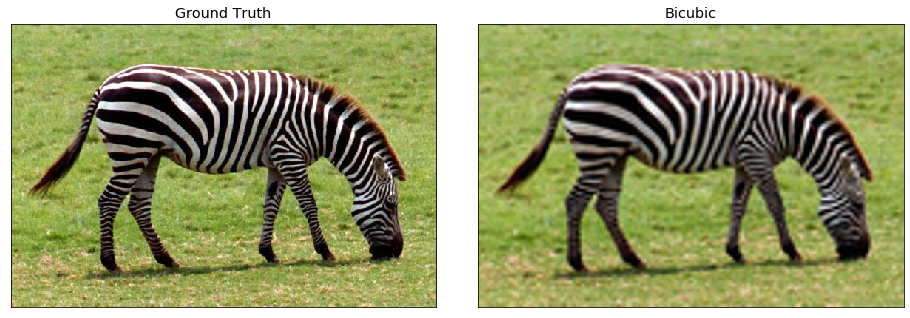

In [5]:
from input_gen import *

img_hr_pil = crop_image(get_image(fname, -1)[0])
img_hr_np = pil_to_np(img_hr_pil)
img_hr_tr = torch.from_numpy(img_hr_np).type(torch.FloatTensor)

hr_width, hr_height = img_hr_pil.size
lr_size = (hr_width // factor, hr_height // factor)
img_lr_pil = img_hr_pil.resize(lr_size, Image.LANCZOS)
img_lr_np = pil_to_np(img_lr_pil)
img_lr_tr = torch.from_numpy(img_lr_np).type(torch.FloatTensor)

img_bicubic_pil = img_lr_pil.resize(img_hr_pil.size, Image.BICUBIC)
img_bicubic_np = pil_to_np(img_bicubic_pil)
img_bicubic_tr = torch.from_numpy(img_bicubic_np).type(torch.FloatTensor)

print(f'Image dim : {img_hr_np.shape}')

fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr],
                              titles=['Ground Truth', 'Bicubic'],
                              figsize=(16,16))

In [6]:
target_img = img_hr_tr
target_img = target_img.unsqueeze(dim=0).to(device)
net_input = get_noise(input_depth, *img_hr_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()

# HyperParmaters for each image
if factor == 4:
    LR = 0.01
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    LR = 0.01
    num_iter = 4000
    reg_noise_std = 1.0/20
        
print(f'Hyperparameters : LR = {LR},  num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : LR = 0.01,  num_iter = 2000,  std = 0.03


C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([3, 96, 144])) that is different to the input size (torch.Size([1, 3, 96, 144])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


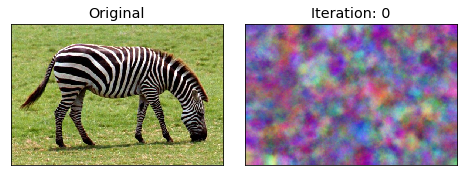

Iteration  100   Loss = 0.012388   PSNR_LR = 19.069818   PSNR_HR=17.50980707 
Iteration  200   Loss = 0.006179   PSNR_LR = 22.090745   PSNR_HR=19.59397373 


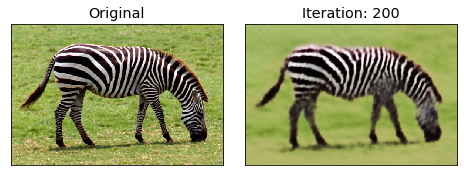

Iteration  300   Loss = 0.004618   PSNR_LR = 23.355717   PSNR_HR=20.37804141 
Iteration  400   Loss = 0.003517   PSNR_LR = 24.537665   PSNR_HR=21.06229090 


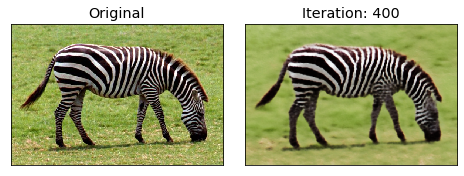

Iteration  500   Loss = 0.002949   PSNR_LR = 25.303723   PSNR_HR=21.47733131 
Iteration  600   Loss = 0.002466   PSNR_LR = 26.080220   PSNR_HR=21.86924444 


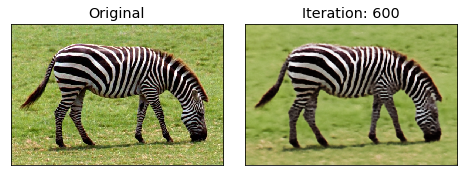

Iteration  700   Loss = 0.002178   PSNR_LR = 26.619863   PSNR_HR=22.13108686 
Iteration  800   Loss = 0.001784   PSNR_LR = 27.485413   PSNR_HR=22.44915454 


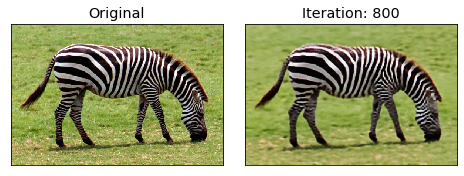

Iteration  900   Loss = 0.001598   PSNR_LR = 27.963090   PSNR_HR=22.72276060 
Iteration  1000   Loss = 0.001454   PSNR_LR = 28.373608   PSNR_HR=22.85629090 


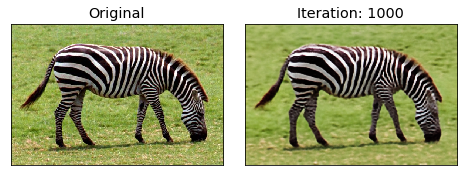

Iteration  1100   Loss = 0.001400   PSNR_LR = 28.539081   PSNR_HR=22.92312727 
Iteration  1200   Loss = 0.001313   PSNR_LR = 28.818900   PSNR_HR=23.00668888 


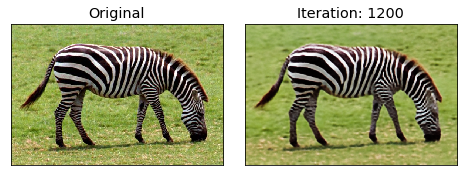

Iteration  1300   Loss = 0.001127   PSNR_LR = 29.481375   PSNR_HR=23.22693030 
Iteration  1400   Loss = 0.001053   PSNR_LR = 29.777711   PSNR_HR=23.34936969 


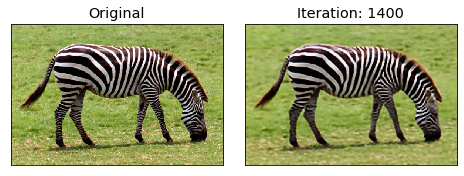

Iteration  1500   Loss = 0.001091   PSNR_LR = 29.621603   PSNR_HR=23.30413939 
Iteration  1600   Loss = 0.000952   PSNR_LR = 30.213905   PSNR_HR=23.44500606 


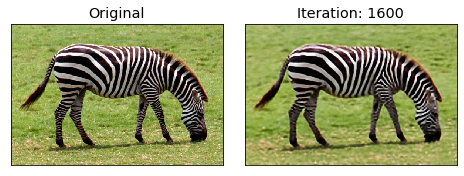

Iteration  1700   Loss = 0.000896   PSNR_LR = 30.476606   PSNR_HR=23.54566565 
Iteration  1800   Loss = 0.000861   PSNR_LR = 30.649998   PSNR_HR=23.56320909 


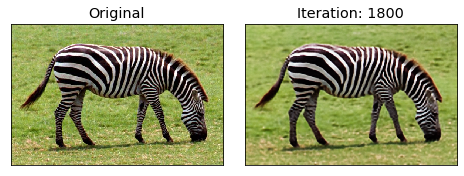

Iteration  1900   Loss = 0.000843   PSNR_LR = 30.739646   PSNR_HR=23.54980000 
Done training final Loss = 0.0007730312063358724   PSNR_LR = 31.11802952560003   PSNR_HR = 23.698258791655235


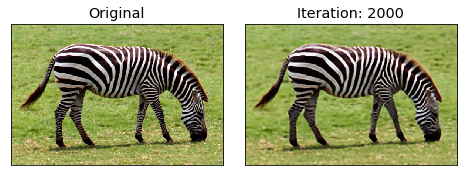

In [7]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
show_every = 100
optimizer = torch.optim.Adam(parameters, lr=LR)

for i in range(num_iter):
    optimizer.zero_grad()
    
    if reg_noise_std > 0:
        net_input_mod = net_input + (noise.normal_() * reg_noise_std)
    else:
        net_input_mod = net_input.clone()
    
    out = net(net_input_mod)
    out_copy = out.detach().cpu()
    out_down = downsampler(out)
    #out_down = downsampler(out).to(device)
    
    loss = mse(out_down, img_lr_tr.to(device))
    loss.backward()
    
    psnr_lr = peak_signal_noise_ratio(img_lr_np, out_down.detach().cpu().numpy()[0]) 
    psnr_hr = peak_signal_noise_ratio(img_hr_np, out_copy.numpy()[0]) 
    
    optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR = %06f' % 
          (i, loss.item(), psnr_lr, psnr_hr), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR=%06f' % 
              (i, loss.item(), psnr_lr, psnr_hr))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_hr_tr, out_copy[0]], 
                                      titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR_LR = {psnr_lr}   PSNR_HR = {psnr_hr}')
fig, axes = tensors_as_images([img_hr_tr, out_copy[0].detach()], 
                                    titles=['Original', f'Iteration: {num_iter}'])

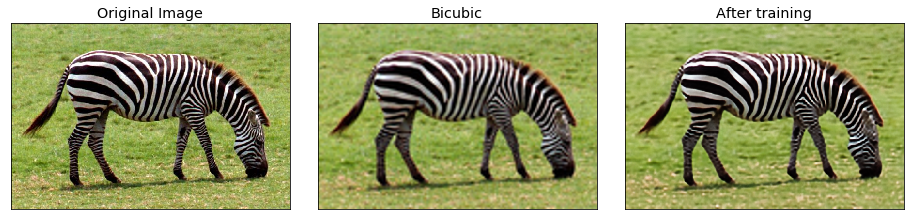

In [8]:
# Showing result of the training using original noise and random noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    
    fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr, output], 
                                        titles=['Original Image', 'Bicubic', 'After training'],
                                        figsize=(16,16))
    
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/sr/{IMAGE}.png')
# will need to use original noise to do denoising

 Best PSNR = 24.026860   Best p = 0.006000


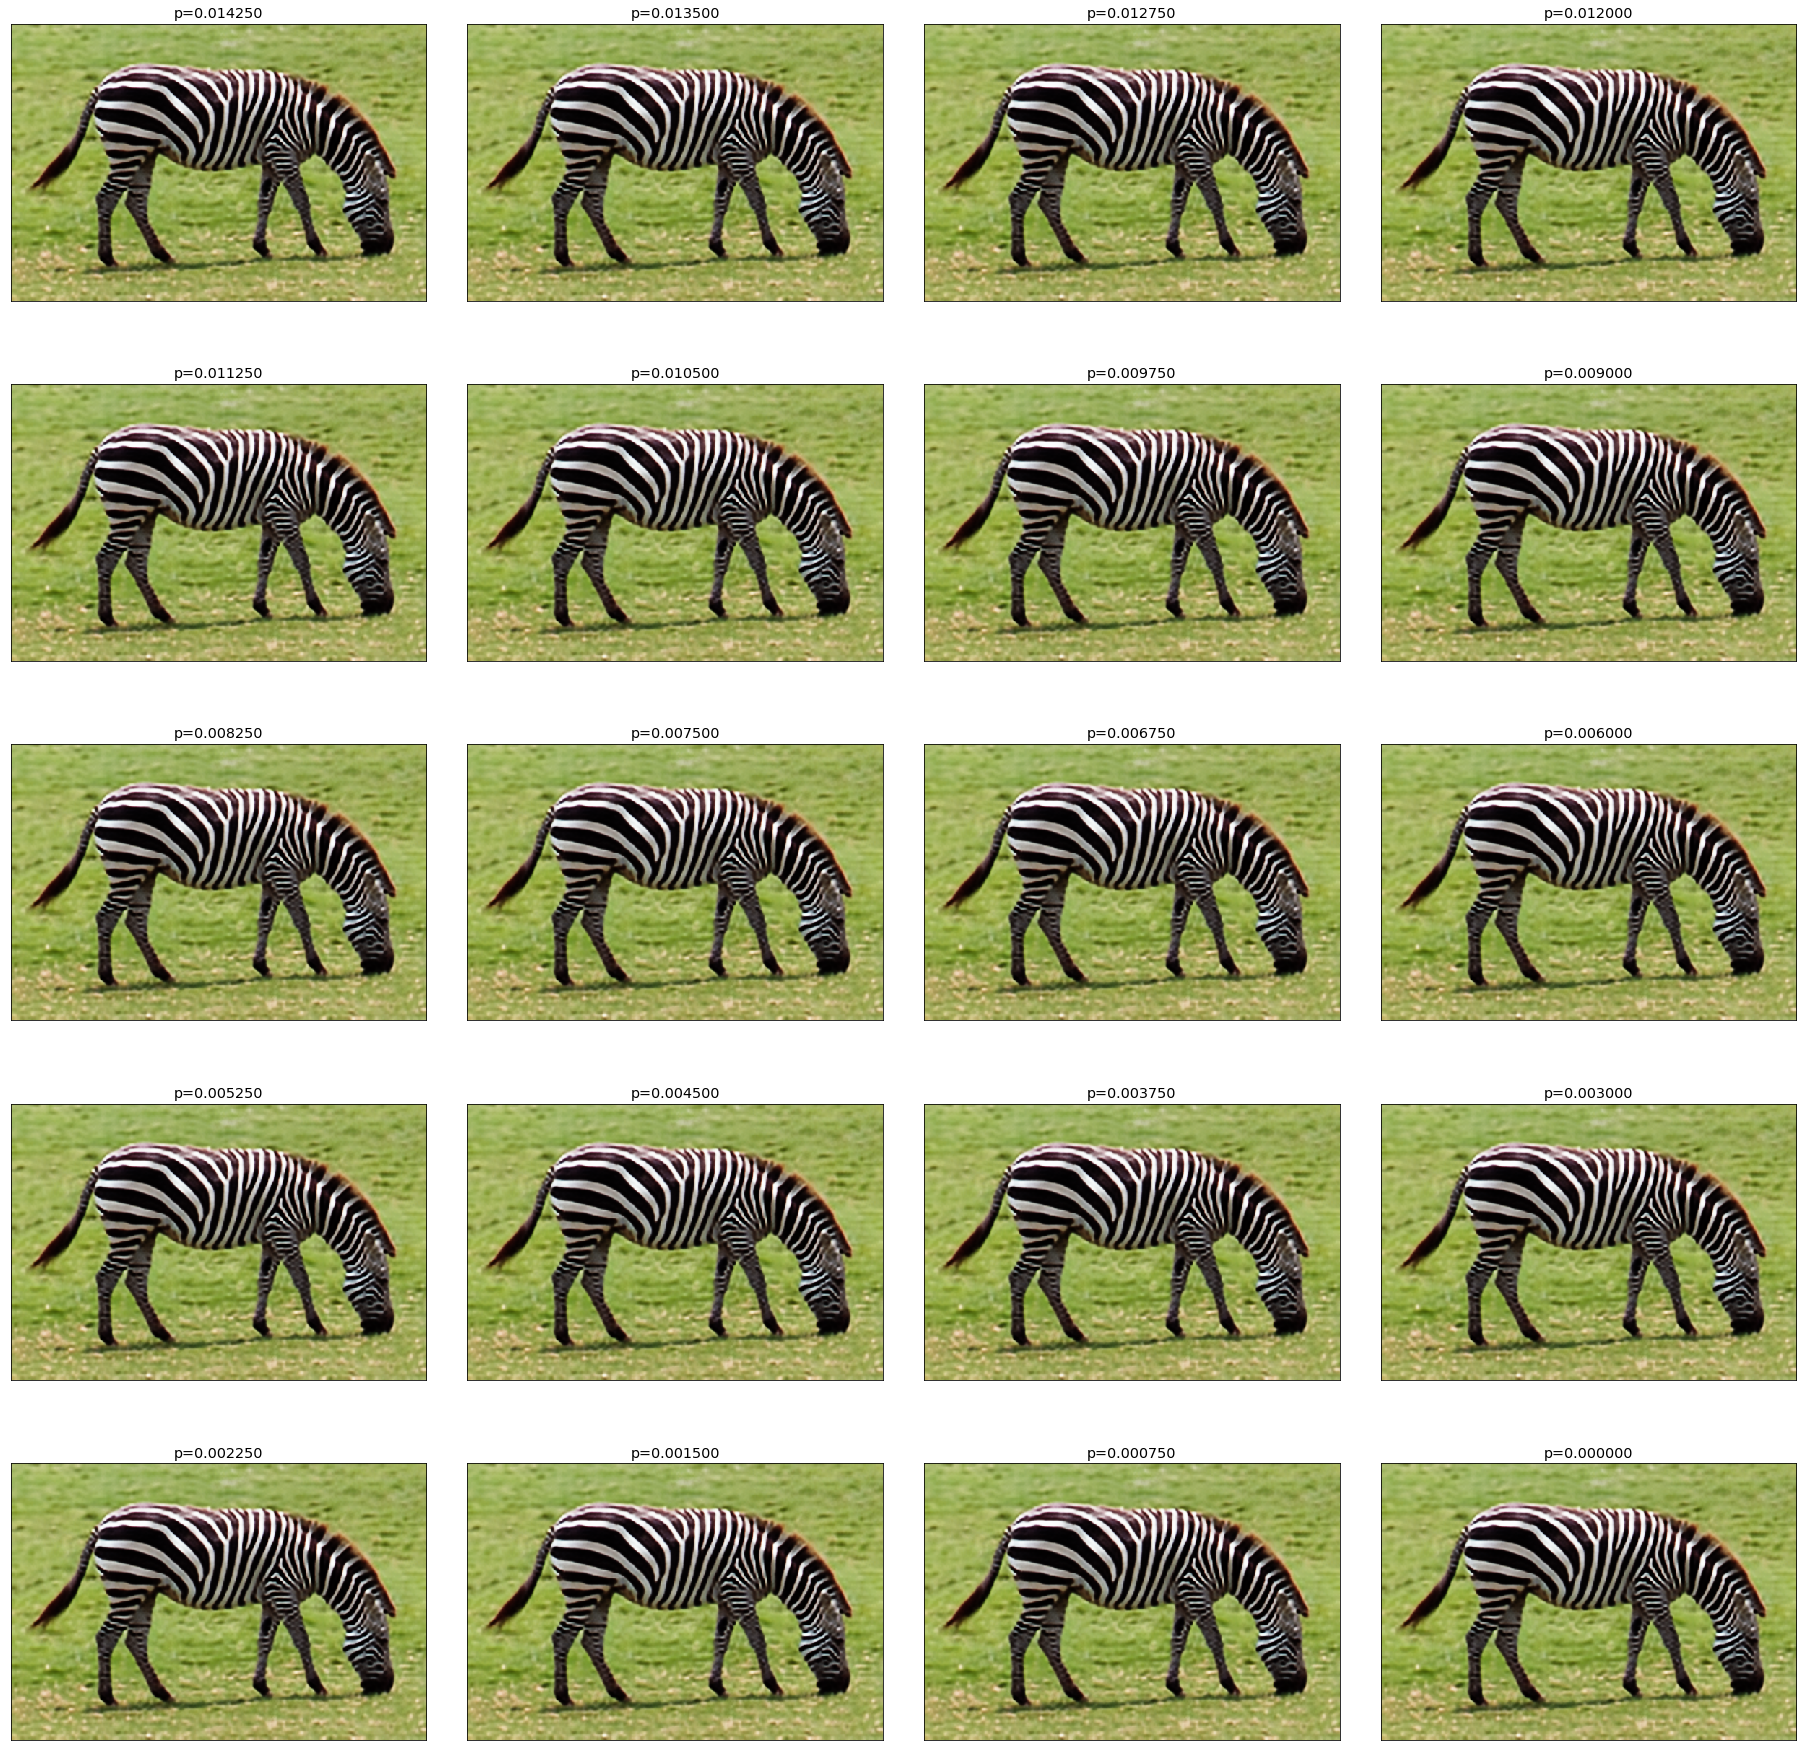

In [9]:
# Try to get better results by changing z_input a bit
with torch.no_grad():
    a = torch.rand(*original_noise.shape)  
    
    best_psnr = 0
    best_p = 0
    results = []
    values = list(np.arange(0.000, 0.015,0.015/20))
    
    for p in reversed(values):
        a[abs(a) > p] = 0
        
        new_noise = original_noise + a.to(device)
        output = net(new_noise).detach()
        psnr_gt = peak_signal_noise_ratio(img_hr_np, output.detach().cpu().numpy()[0]) 
        output = output.squeeze(dim=0)
        results.append(output.clone())
        
        if psnr_gt > best_psnr:
            best_psnr = psnr_gt
            best_p = p
            
    print(f' Best PSNR = %f   Best p = %f' % (best_psnr, best_p))
    nrows = int(len(values)/4)
    fig, axes = tensors_as_images(results, titles=[f'p=%f' % p for p in reversed(values)],
                                        nrows=nrows, figsize=(32,32), cmap='Greys')
        